Step 1 : Problem statement
We aim to understand the difference in user behaviors between two versions (gate_30 and gate_40) of the Cookie Cats game. Specifically, we will analyze the variable "sum_gamerounds," representing the number of rounds played by users.

Step 2: Formulation of Hypotheses
Null Hypothesis (H0): There is no statistically significant difference in the number of rounds played between the two versions.

Alternative Hypothesis (H1): There is a statistically significant difference in the number of rounds played between the two versions.

Step 3: Exploration of the Data
Let's start by loading the dataset and examining basic statistical information:

Load the Dataset:
This section loads the Cookie Cats dataset into a pandas dataframe.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, chisquare
import pandas as pd
import numpy as np

C:\Users\vkhosla\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\vkhosla\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\vkhosla\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv(r'downloads\cookie_cats.csv')
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


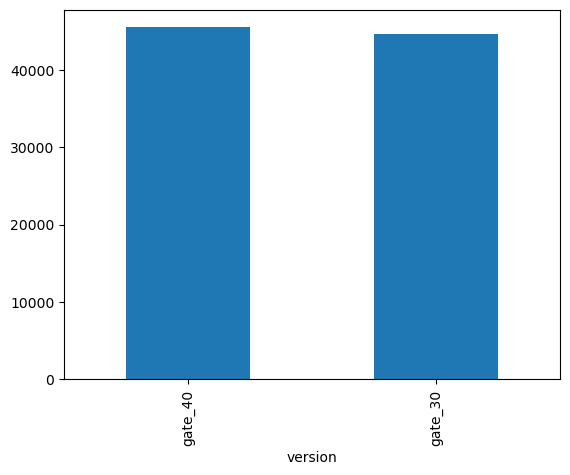

In [3]:
#basic eda check the record counts for versions
print(data['version'].value_counts())
data['version'].value_counts().plot(kind = 'bar');

In [33]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


sum_gamerounds is 49854 for one record which looks in incorrect . So we can remove this record if we were testing for difference between game rounds played by players

In [13]:
#SRM test using Chisquare to check for Sample Ratio Mismatch
def SRM(dataframe):
    gate_30 = dataframe["version"].value_counts().loc["gate_30"]
    gate_40 = dataframe["version"].value_counts().loc["gate_40"]

    print("Number of players in group A (gate_30):",gate_30)
    print("Number of players in group B (gate_40):",gate_40)
    
    observed = [ gate_30, gate_40 ]
    total_player= sum(observed)
    expected = [ total_player/2, total_player/2 ]

    chi = chisquare(observed, f_exp=expected)
    print(f"p-value: {round(chi[1], 4)}\n")
    if chi[1] < 0.01:
        print('SRM detected')
    else:
        print('No SRM detected')
SRM(data)

Number of players in group A (gate_30): 44700
Number of players in group B (gate_40): 45489
p-value: 0.0086

SRM detected


The Chisquare test shows that there is a sample ratio mismatch eventhough the same size is relatively close. One way to resolve this to generate a sample randomly from the existing data. We do this by using sample function with each sample having 44000 records

In [14]:
control = data[data['version'] == 'gate_30']
treatment = data[data['version'] == 'gate_40']
balanced_data = pd.concat([
    control.sample(n = 44000, axis = 'index', random_state = 222),
    treatment.sample(n = 44000, axis = 'index', random_state = 222)
], ignore_index = True)

In [15]:
#Test for SRM for the new data-set
SRM(balanced_data)

Number of players in group A (gate_30): 44000
Number of players in group B (gate_40): 44000
p-value: 1.0

No SRM detected


In [16]:
#Generate datasets for 1 day and 7 day retention to use for hypothesis test
day_retention = pd.crosstab(balanced_data["version"], balanced_data["retention_1"])
week_retention = pd.crosstab(balanced_data["version"], balanced_data["retention_7"])

In [17]:
day_retention

retention_1,False,True
version,,
gate_30,24276,19724
gate_40,24533,19467


In [18]:
week_retention

retention_7,False,True
version,,
gate_30,35615,8385
gate_40,35979,8021


In [19]:
# define a function with ch2_contigency. Note: FOr comparing two variables chi-sqaure 
# and z proportion 2 sample test give same results
def chi2test(data):
    _, p, _, _ = chi2_contingency(data)
    significance_level = 0.05

    print(f"p-value = {round(p, 4)}, significance level = {significance_level}")
    if p > significance_level:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [20]:
chi2test(day_retention)

p-value = 0.0825, significance level = 0.05
Two groups have no significant difference


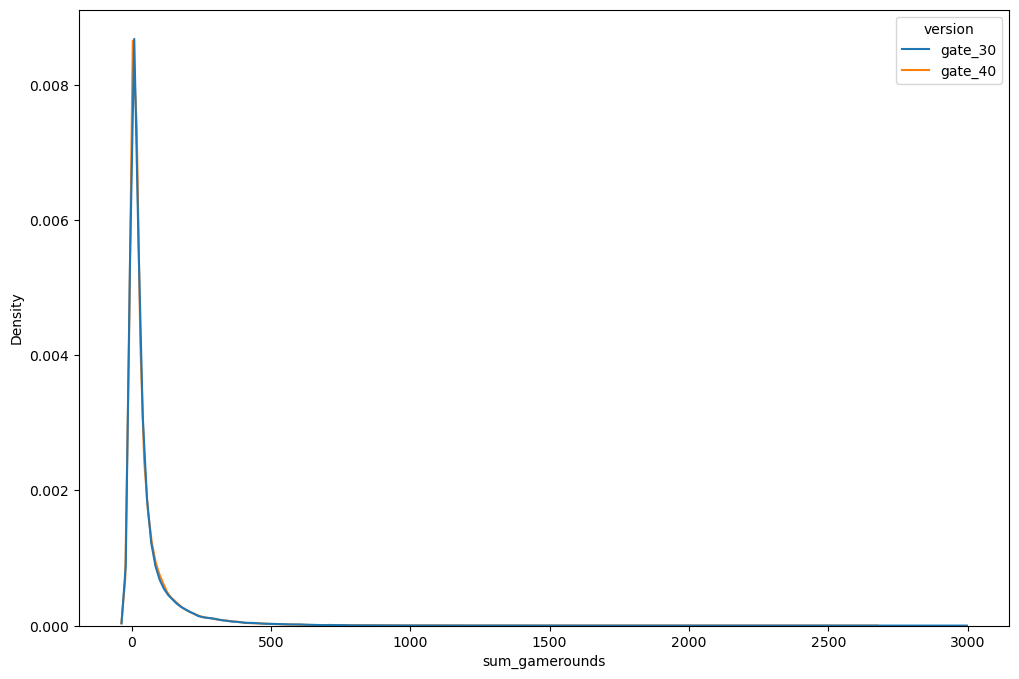

In [6]:
df = data[data['sum_gamerounds']!=49854]
plt.figure(figsize=(12,8))
sns.kdeplot(x = 'sum_gamerounds' , data = df , hue = 'version')
plt.show()